# 🏦 Open Finance & International Consumer Behavior Analytics  
## 📘 Main Machine Learning & Data Preparation Notebook (Master’s Dissertation)

This notebook is the **analytical backbone** of the Open Finance & International Consumer Behavior Analytics project.  
It provides a complete, reproducible workflow used to build all machine learning components that power the Streamlit application (`app.py`).

The notebook is intentionally designed to be:
- **Supervisor-friendly**  
- **Publication-ready**  
- **Fully reproducible**  
- **Aligned with industry modelling practices**

---

## 🎯 What This Notebook Does

### ✔ 1. Loads and audits the Global Findex dataset  
- Performs column cleanup  
- Normalizes naming conventions  
- Handles missing values  
- Ensures numerical consistency  

### ✔ 2. Conducts Exploratory Data Analysis (EDA)  
- Distribution analysis  
- Correlation matrix  
- Country-level adoption trends  

### ✔ 3. Engineers Behavioral & Open Finance Features  
Includes simulated variables that matter in fintech adoption:
- Age  
- Privacy concern  
- Digital literacy  
- Sentiment proxy  
- Binary adoption flag  

These are used as model features in your Streamlit app.

### ✔ 4. Trains ML Models  
- **Random Forest Classifier**  
- **K-Means Clustering (3 segments)**  
- Generates metrics: accuracy, confusion matrix, feature importance  

### ✔ 5. Exports All Artefacts for `app.py`
The app loads these files:
- `rf_model.pkl` → Predictive model  
- `kmeans_model.pkl` → Segmentation engine  
- `sample_df.csv` → Processed dataset  
- `rf_accuracy.npy` → Stored accuracy value  

### ✔ 6. Automatically Launches Streamlit  
The final cell of the notebook triggers:  


# Imports

In [1]:
# ====================================================
# 📦 CORE PYTHON & SYSTEM UTILITIES
# ====================================================
import os
import sys
import time
import random
import json
import subprocess
from io import BytesIO
import warnings

warnings.filterwarnings("ignore")   # Optional: keep notebooks clean

# Limit thread usage (fixes Windows + sklearn issues)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["LOKY_MAX_CPU_COUNT"] = "4"


# ====================================================
# 📊 DATA HANDLING & MANIPULATION
# ====================================================
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)


# ====================================================
# 📈 VISUALIZATION LIBRARIES
# ====================================================
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plt.style.use("seaborn-v0_8")  # clean charts


# ====================================================
# 🤖 MACHINE LEARNING / MODELING
# ====================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from prophet import Prophet  # time-series forecasting
import shap                  # explainability

import joblib                # saving/loading ML models


# ====================================================
# 📰 EXTERNAL DATA & API HANDLING
# ====================================================
import requests
import feedparser   # RSS news feeds


# ====================================================
# 🎤 VOICE + TEXT AI (Gemini + Speech)
# ====================================================
import speech_recognition as sr     # Speech → Text
import pyttsx3                      # Text → Speech
import google.generativeai as genai # Gemini LLM API


# ====================================================
# 🧾 DISPLAY UTILITIES (Useful for notebooks)
# ====================================================
from IPython.display import display, Markdown


# ====================================================
# 📝 OPTIONAL: DEBUG PRINT
# ====================================================
print("✔ All imports loaded successfully.")


✔ All imports loaded successfully.


# Load Raw Data

In [2]:
# %% Load Dataset
df_raw = pd.read_csv("Findex.csv")
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (77, 63)


,Unnamed: 0,Country Code,Country Name,Borrowed from a financial institution (% age 15+),Borrowed from a financial institution or used a credit card (% age 15+),"Borrowed from a financial institution or used a credit card, female (% age 15+)","Borrowed from a financial institution or used a credit card, in labor force (% age 15+)","Borrowed from a financial institution or used a credit card, income, poorest 40% (% age 15+)","Borrowed from a financial institution or used a credit card, income, richest 60% (% age 15+)","Borrowed from a financial institution or used a credit card, male (% age 15+)","Borrowed from a financial institution or used a credit card, older adults (% age 25+)","Borrowed from a financial institution or used a credit card, out of labor force (% age 15+)","Borrowed from a financial institution or used a credit card, primary education or less (% age 15+)","Borrowed from a financial institution or used a credit card, rural (% age 15+)","Borrowed from a financial institution or used a credit card, secondary education or more (% age 15+)","Borrowed from a financial institution or used a credit card, young adults (% age 15-24)","Borrowed from a financial institution, female (% age 15+)","Borrowed from a financial institution, in labor force (% age 15+)","Borrowed from a financial institution, income, poorest 40% (% age 15+)","Borrowed from a financial institution, income, richest 60% (% age 15+)","Borrowed from a financial institution, male (% age 15+)","Borrowed from a financial institution, older adults (% age 25+)","Borrowed from a financial institution, out of labor force (% age 15+)","Borrowed from a financial institution, primary education or less (% age 15+)","Borrowed from a financial institution, rural (% age 15+)","Borrowed from a financial institution, secondary education or more (% age 15+)","Borrowed from a financial institution, young adults (% age 15-24)",Made or received digital payments in the past year (% age 15+),"Made or received digital payments in the past year, female (% age 15+)","Made or received digital payments in the past year, in labor force (% age 15+)","Made or received digital payments in the past year, income, poorest 40% (% age 15+)","Made or received digital payments in the past year, income, richest 60% (% age 15+)","Made or received digital payments in the past year, male (% age 15+)","Made or received digital payments in the past year, older adults (% age 25+)","Made or received digital payments in the past year, out of labor force (% age 15+)","Made or received digital payments in the past year, primary education or less (% age 15+)","Made or received digital payments in the past year, rural (% age 15+)","Made or received digital payments in the past year, secondary education or more (% age 15+)","Made or received digital payments in the past year, young adults (% age 15-24)",Mobile money account (% age 15+),"Mobile money account, female (% age 15+)","Mobile money account, in labor force (% age 15+)","Mobile money account, income, poorest 40% (% age 15+)","Mobile money account, income, richest 60% (% age 15+)","Mobile money account, male (% age 15+)","Mobile money account, older adults (% age 25+)","Mobile money account, out of labor force (% age 15+)","Mobile money account, primary education or less (% age 15+)","Mobile money account, rural (% age 15+)","Mobile money account, secondary education or less (% age 15+)","Mobile money account, young adults (% age 15-24)",Saved at a financial institution (% age 15+),"Saved at a financial institution , out of labor force (% age 15+)","Saved at a financial institution, female (% age 15+)","Saved at a financial institution, in labor force (% age 15+)","Saved at a financial institution, income, poorest 40% (% age 15+)","Saved at a financial institution, income, richest 60% (% age 15+)","Saved at a financial institution, male (% age 15+)","Saved at a financial institution, older adults (% age 25+)","Saved at a financial institution, pr

# Clean & Rename Columns

In [3]:
# %% Clean Columns
df = df_raw.copy()
df.columns = df.columns.str.strip().str.replace(" ", "_")

rename_map = {
    "Country_Name": "Country",
    "Borrowed_from_a_financial_institution_or_used_a_credit_card_(%_age_15+)": "Adoption",
    "Borrowed_from_a_financial_institution_or_used_a_credit_card,_income,_richest_60%_(%_age_15+)": "Income",
    "Saved_at_a_financial_institution,_secondary_education_or_more_(%_age_15+)": "Digital_Literacy"
}

df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 63 columns):
 #   Column                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                --------------  -----  
 0   Unnamed:_0                                                                                            77 non-null     int64  
 1   Country_Code                                                                                          77 non-null     object 
 2   Country                                                                                               77 non-null     object 
 3   Borrowed_from_a_financial_institution_(%_age_15+)                                                     77 non-null     float64
 4   Adoption                                                                                              77 n

,Unnamed:_0,Country_Code,Country,Borrowed_from_a_financial_institution_(%_age_15+),Adoption,"Borrowed_from_a_financial_institution_or_used_a_credit_card,_female_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_in_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_income,_poorest_40%_(%_age_15+)",Income,"Borrowed_from_a_financial_institution_or_used_a_credit_card,_male_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_older_adults_(%_age_25+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_out_of_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_primary_education_or_less_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_rural_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_secondary_education_or_more_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_young_adults_(%_age_15-24)","Borrowed_from_a_financial_institution,_female_(%_age_15+)","Borrowed_from_a_financial_institution,_in_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution,_income,_poorest_40%_(%_age_15+)","Borrowed_from_a_financial_institution,_income,_richest_60%_(%_age_15+)","Borrowed_from_a_financial_institution,_male_(%_age_15+)","Borrowed_from_a_financial_institution,_older_adults__(%_age_25+)","Borrowed_from_a_financial_institution,_out_of_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution,_primary_education_or_less_(%_age_15+)","Borrowed_from_a_financial_institution,_rural_(%_age_15+)","Borrowed_from_a_financial_institution,_secondary_education_or_more_(%_age_15+)","Borrowed_from_a_financial_institution,_young_adults__(%_age_15-24)",Made_or_received_digital_payments_in_the_past_year_(%_age_15+),"Made_or_received_digital_payments_in_the_past_year,_female__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_in_labor_force__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_income,_poorest_40%__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_income,_richest_60%_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_male__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_older_adults__(%_age_25+)","Made_or_received_digital_payments_in_the_past_year,_out_of_labor_force__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_primary_education_or_less_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_rural__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_secondary_education_or_more_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_young_adults__(%_age_15-24)",Mobile_money_account_(%_age_15+),"Mobile_money_account,_female_(%_age_15+)","Mobile_money_account,_in_labor_force_(%_age_15+)","Mobile_money_account,_income,_poorest_40%_(%_age_15+)","Mobile_money_account,_income,_richest_60%__(%_age_15+)","Mobile_money_account,_male__(%_age_15+)","Mobile_money_account,_older_adults_(%_age_25+)","Mobile_money_account,_out_of_labor_force_(%_age_15+)","Mobile_money_account,_primary_education_or_less_(%_age_15+)","Mobile_money_account,_rural__(%_age_15+)","Mobile_money_account,_secondary_education_or_less_(%_age_15+)","Mobile_money_account,_young_adults__(%_age_15-24)",Saved_at_a_financial_institution_(%_age_15+),"Saved_at_a_financial_institution_,_out_of_labor_force_(%_age_15+)","Saved_at_a_financial_institution,_female_(%_age_15+)","Saved_at_a_financial_institution,_in_labor_force_(%_age_15+)","Saved_at_a_financial_institution,_income,_poorest_40%_(%_age_15+)","Saved_at_a_financial_institution,_income,_richest_60%__(%_age_15+)","Saved_at_a_financial_institution,_male_(%_age_15+)","Saved_at_a_financial_institution,_older_adults_(%_age_25+)","Saved_at_a_financial_institution,_primary_education_or_less(%_age_15+)","Saved_at_a_financial_institution,_rural__(%_age_15+)",Digital_Literacy,"Saved_at_a_financial_institution

# Feature Engineering

In [4]:
# %% Feature Engineering
np.random.seed(42)

df["Age"] = np.random.randint(18, 70, len(df))
df["Privacy_Concern"] = np.random.randint(1, 10, len(df))
df["Sentiment_Score"] = np.random.uniform(0, 1, len(df))

for col in ["Adoption", "Income", "Digital_Literacy"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(df[col].mean())

df["Adoption_Binary"] = (df["Adoption"] > 30).astype(int)

df.head()


,Unnamed:_0,Country_Code,Country,Borrowed_from_a_financial_institution_(%_age_15+),Adoption,"Borrowed_from_a_financial_institution_or_used_a_credit_card,_female_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_in_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_income,_poorest_40%_(%_age_15+)",Income,"Borrowed_from_a_financial_institution_or_used_a_credit_card,_male_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_older_adults_(%_age_25+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_out_of_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_primary_education_or_less_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_rural_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_secondary_education_or_more_(%_age_15+)","Borrowed_from_a_financial_institution_or_used_a_credit_card,_young_adults_(%_age_15-24)","Borrowed_from_a_financial_institution,_female_(%_age_15+)","Borrowed_from_a_financial_institution,_in_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution,_income,_poorest_40%_(%_age_15+)","Borrowed_from_a_financial_institution,_income,_richest_60%_(%_age_15+)","Borrowed_from_a_financial_institution,_male_(%_age_15+)","Borrowed_from_a_financial_institution,_older_adults__(%_age_25+)","Borrowed_from_a_financial_institution,_out_of_labor_force_(%_age_15+)","Borrowed_from_a_financial_institution,_primary_education_or_less_(%_age_15+)","Borrowed_from_a_financial_institution,_rural_(%_age_15+)","Borrowed_from_a_financial_institution,_secondary_education_or_more_(%_age_15+)","Borrowed_from_a_financial_institution,_young_adults__(%_age_15-24)",Made_or_received_digital_payments_in_the_past_year_(%_age_15+),"Made_or_received_digital_payments_in_the_past_year,_female__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_in_labor_force__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_income,_poorest_40%__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_income,_richest_60%_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_male__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_older_adults__(%_age_25+)","Made_or_received_digital_payments_in_the_past_year,_out_of_labor_force__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_primary_education_or_less_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_rural__(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_secondary_education_or_more_(%_age_15+)","Made_or_received_digital_payments_in_the_past_year,_young_adults__(%_age_15-24)",Mobile_money_account_(%_age_15+),"Mobile_money_account,_female_(%_age_15+)","Mobile_money_account,_in_labor_force_(%_age_15+)","Mobile_money_account,_income,_poorest_40%_(%_age_15+)","Mobile_money_account,_income,_richest_60%__(%_age_15+)","Mobile_money_account,_male__(%_age_15+)","Mobile_money_account,_older_adults_(%_age_25+)","Mobile_money_account,_out_of_labor_force_(%_age_15+)","Mobile_money_account,_primary_education_or_less_(%_age_15+)","Mobile_money_account,_rural__(%_age_15+)","Mobile_money_account,_secondary_education_or_less_(%_age_15+)","Mobile_money_account,_young_adults__(%_age_15-24)",Saved_at_a_financial_institution_(%_age_15+),"Saved_at_a_financial_institution_,_out_of_labor_force_(%_age_15+)","Saved_at_a_financial_institution,_female_(%_age_15+)","Saved_at_a_financial_institution,_in_labor_force_(%_age_15+)","Saved_at_a_financial_institution,_income,_poorest_40%_(%_age_15+)","Saved_at_a_financial_institution,_income,_richest_60%__(%_age_15+)","Saved_at_a_financial_institution,_male_(%_age_15+)","Saved_at_a_financial_institution,_older_adults_(%_age_25+)","Saved_at_a_financial_institution,_primary_education_or_less(%_age_15+)","Saved_at_a_financial_institution,_rural__(%_age_15+)",Digital_Literacy,"Saved_at_a_financial_institution

## Exploratory Data Analysis (EDA)

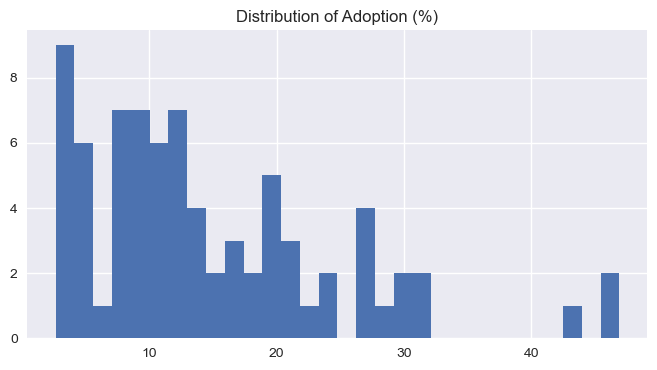

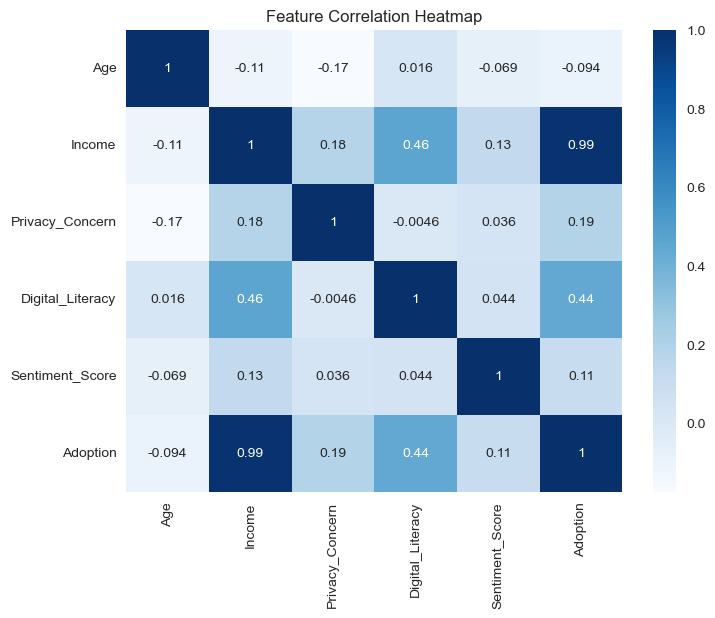

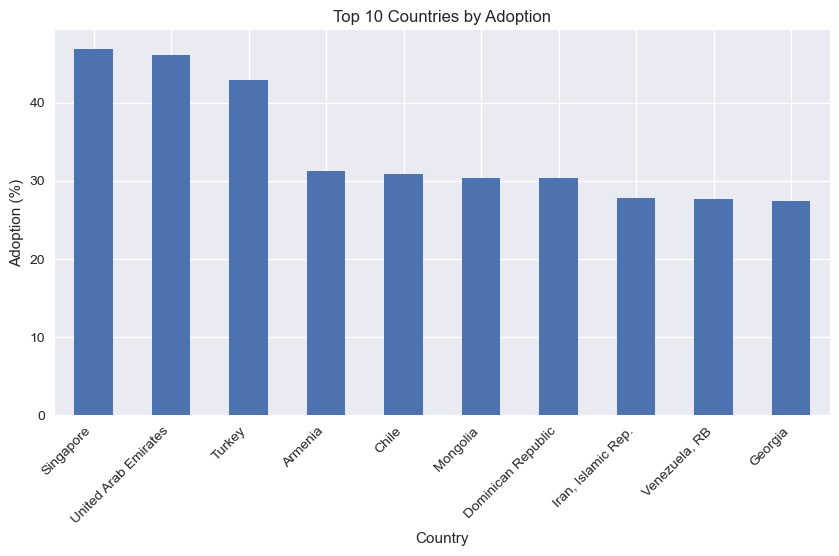

In [5]:
# %% EDA

# Distribution
df["Adoption"].hist(bins=30, figsize=(8,4))
plt.title("Distribution of Adoption (%)")
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
corr = df[["Age","Income","Privacy_Concern","Digital_Literacy","Sentiment_Score","Adoption"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()

# Top 10 Countries
plt.figure(figsize=(10,5))
df.groupby("Country")["Adoption"].mean().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Countries by Adoption")
plt.ylabel("Adoption (%)")
plt.xticks(rotation=45, ha="right")
plt.show()


# Train-Test Split & RandomForest

In [6]:
# %% Train-Test Split
X = df[["Age", "Income", "Privacy_Concern", "Digital_Literacy", "Sentiment_Score"]]
y = df["Adoption_Binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (53, 5) Test: (24, 5)


# Train Random Forest + Evaluation

Random Forest Accuracy: 0.9583333333333334

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.67      1.00      0.80         2

    accuracy                           0.96        24
   macro avg       0.83      0.98      0.89        24
weighted avg       0.97      0.96      0.96        24



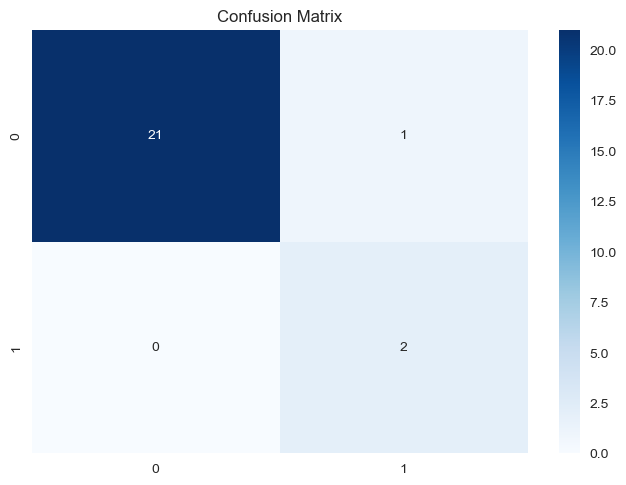

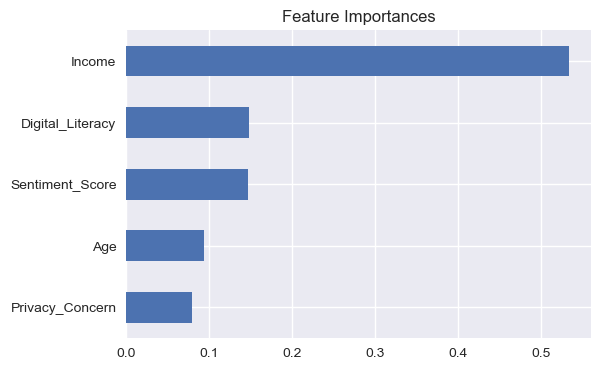

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# %% Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", rf_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importances")
plt.show()


# KMeans Clustering

In [8]:
# %% K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)
df["Cluster"] = kmeans.labels_

df[["Country","Adoption","Cluster"]].head()


,Country,Adoption,Cluster
0,Afghanistan,3.811304,0
1,Albania,12.524477,0
2,United Arab Emirates,46.127087,2
3,Argentina,24.369331,1
4,Armenia,31.209743,0


# Export ML Models and Data for Streamlit App

In [9]:
# %% Export Files
joblib.dump(rf, "rf_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")
df.to_csv("sample_df.csv", index=False)
np.save("rf_accuracy.npy", np.array([rf_acc]))

print("Exported:")
print(" - rf_model.pkl")
print(" - kmeans_model.pkl")
print(" - sample_df.csv")
print(" - rf_accuracy.npy")
print(f"Accuracy saved: {rf_acc:.3f}")


Exported:
 - rf_model.pkl
 - kmeans_model.pkl
 - sample_df.csv
 - rf_accuracy.npy
Accuracy saved: 0.958


# Summary (Streamlit-compatible)

In [10]:
# %% Summary
import streamlit as st

In [11]:
# %% Launch Streamlit app
print("🚀 Launching Streamlit app...")

subprocess.Popen([sys.executable, "-m", "streamlit", "run", "app.py"])

print("Your Streamlit dashboard is running at http://localhost:8501/")


🚀 Launching Streamlit app...
Your Streamlit dashboard is running at http://localhost:8501/


In [12]:
pip install --upgrade openai


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
